## <center>CITS5508 Lab sheet 3: Decision Tree Classification</center>

**Name: Samuel Heath**<br>
**Student number: 21725083**<br>

## Project 1 - UCI ecoli Dataset
### Summary:
- Load and clean data.
- Remove Classes that dont have enough instances.
- Remove unneeded features and scale the dataset.
- Compare DT Classifier and SVM Classifier results based on trained data sets.

##### Load Data from `./ecoli.data` and initially visualise the data to see if any classes cant be used.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Set the random seed to ensusre consistent results
random_seed = 12

# Lables we want to add to the data
labels = ["sequence", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "label"]
ecoli_data = pd.read_csv('./ecoli.data', delim_whitespace=True, names=labels)

ecoli_data = ecoli_data.drop("sequence", axis=1)

ecoli_data.describe()

,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


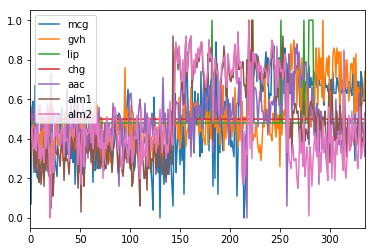

In [2]:
ecoli_data.plot()
plt.show()

From the plot above we see that the `lip` and `chg` features are not particularly good features as they stay relativelt flat around 0.5 but at times rise to 1.0, and dont show much variation. Based on these features I've decided to remove them as I believe they will effect the prediction accuracy of my models.

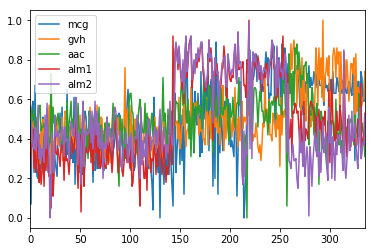

In [3]:
ecoli_data = ecoli_data.drop(["lip", "chg"], axis=1)

ecoli_data.plot()
plt.show()

Check the class distribution and remove classes with < 10 as we cannot accurately train a model on these classes

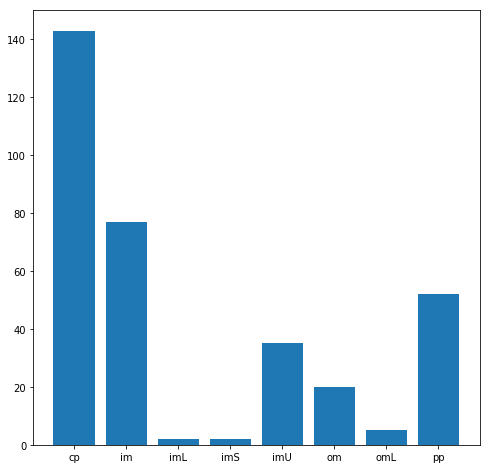

In [4]:
ecoli_data_copy = ecoli_data.copy()

plt.figure(figsize=(8, 8))
plt.bar(x=ecoli_data_copy.sort_values('label')['label'].unique(), height=ecoli_data_copy.groupby('label').size())
plt.show()

From this we see that imL, imS, and omL cannot be used for classificiation due to their low number of training instances, so lets remove these classes from the dataset. We also see there is quite a lot of class imbalance with some classes having over 80 instances whilst others only have 20, when splitting the data we will need to make sure this is considered.

In [5]:
# Drop rows where these classes are assigned.
ecoli_data = ecoli_data.drop(ecoli_data[ecoli_data.label.isin(["imL", "imS", "omL"])].index)
ecoli_data.reset_index()

ecoli_data_copy = ecoli_data.copy()

# Check that it was removed
ecoli_data.head()

,mcg,gvh,aac,alm1,alm2,label
0,0.49,0.29,0.56,0.24,0.35,cp
1,0.07,0.40,0.54,0.35,0.44,cp
2,0.56,0.40,0.49,0.37,0.46,cp
3,0.59,0.49,0.52,0.45,0.36,cp
4,0.23,0.32,0.55,0.25,0.35,cp


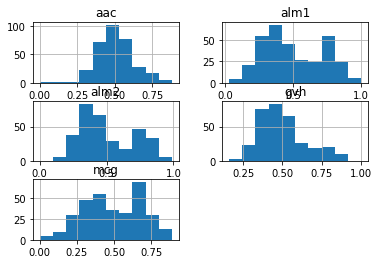

In [6]:
ecoli_data[["aac","alm1","alm2","gvh","mcg"]].hist()
plt.show()

From the above histograms we see that the features do not follow a normal distribution with the exception of the `aac` feature. When scaling we should probably use the MinMaxScaler instead.

## Split the dataset into training and testing datasets
Before we learn against this dataset we need to separate out our set into a training and testing set allowing us to validated the accuracy of our model. Peform the split using StratifiedShuffleSplit, resulting in a test size of 20% and training size of 80%. StratifiedShuffleSplit shuffles the dataset once before attempting to evenly distribute (based on the distribution of values) the samples of each label (`ecoli_data.label`) into both the training and testing datasets. This even distribution of the classes is highly important as we noted earlier there was quite a lot of class imbalance.

In [7]:
from sklearn.preprocessing import LabelEncoder

# We will also need to convert the labels to text to help the classifiers work.
le = LabelEncoder()
ecoli_data.label = le.fit_transform(ecoli_data.label)
ecoli_data.label.describe()

count    327.000000
mean       1.269113
std        1.467770
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: label, dtype: float64

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Shuffle then split the dataset into 80/20 (training/testing) sets
sss = StratifiedShuffleSplit(random_state=random_seed, test_size=0.2, train_size=0.8)

# Have not separated the labels before performing the split as it was just easier initially.

# Perform the split and assign the X_train and X_test sets, then
for train_index, test_index in sss.split(ecoli_data, ecoli_data.label):
    X_train, X_test = ecoli_data.iloc[train_index], ecoli_data.iloc[test_index]    
    
# Get the labels of the dataset
y_train, y_test = X_train.label, X_test.label

# Drop Labels from X
X_train = X_train.drop("label", axis=1)
X_test = X_test.drop("label", axis=1)

Scale the training and testing data sets so that SVM can better fit the data, and so we can compare the scaled and unscaled models.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit the data to a Model
Make two different models of the data using Support Vector Machines and Decision Trees

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create a Decision Tree
dt = DecisionTreeClassifier(min_samples_leaf=10, random_state=random_seed).fit(X_train_scaled, y_train)
dt_test_predict = dt.predict(X_test_scaled)

# Create a Support Vector Classifier
svm = SVC(gamma="auto", C=3, kernel="linear", decision_function_shape="ovo", random_state=random_seed).fit(X_train_scaled, y_train)
svm_test_predict = svm.predict(X_test_scaled)

For the Decision Tree `min_samples_leaf` at 10 appeared to improve the DT's f1 score by 2% hence was selected.

`Linear` Kernal was selected from trial and error it appeared to give me the best result on the test data set. As was using gamma `scale`.

### Accuracy of Fitted Models
Compare the accuracy of the fitted models using their cross validated prediction accuracy, f1 score, their confusion matrices.

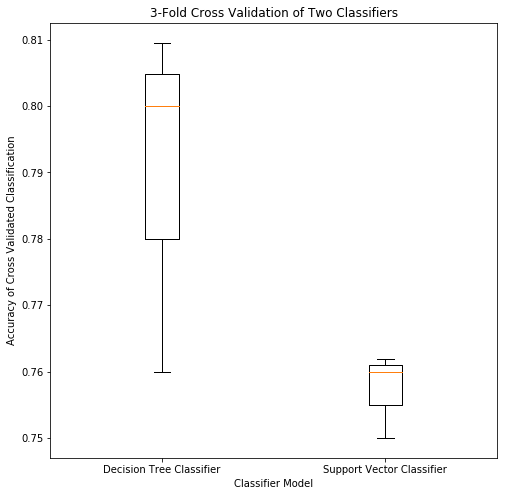

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

dt_y_predict = cross_val_score(dt, X_test_scaled, y_test, cv=3)
svm_y_predict = cross_val_score(svm, X_test_scaled, y_test, cv=3)

plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, svm_y_predict], labels=["Decision Tree Classifier", "Support Vector Classifier"])
plt.title("3-Fold Cross Validation of Two Classifiers")
plt.ylabel("Accuracy of Cross Validated Classification")
plt.xlabel("Classifier Model")
plt.show()

In [12]:
# Use micro as it averages across all of the predicted classes.
dt_f1 = f1_score(y_test, dt_test_predict, average="micro")
svm_f1 = f1_score(y_test, svm_test_predict, average="micro")

print("(%.6f%%, %.6f%%)" % (dt_f1, svm_f1))

(0.863636%, 0.909091%)


Based on the f1 scores of these classifiers we can see that the SVC achieves an f1 score of 90.9% and appears to be more accurate than the DTC's 86.4%. Lets see if there is some difference in thier accuracy in predicting the different classes.

In [13]:
def plot_confusion_matrix(matrix, title=""):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.title(title)
    
    locs, labels = plt.xticks()
    # Because labels are not applied at the 0 location we need an extra label to ensure its displayed
    labels = ["0"]
    labels.extend(le.inverse_transform(range(0, 5)))
    plt.xticks(locs, labels)
    y_loc, y_label = plt.yticks()
    plt.yticks(y_loc, labels)
    
    for i in range(5):
        for j in range(5):
            c = matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center', color='black')
    
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

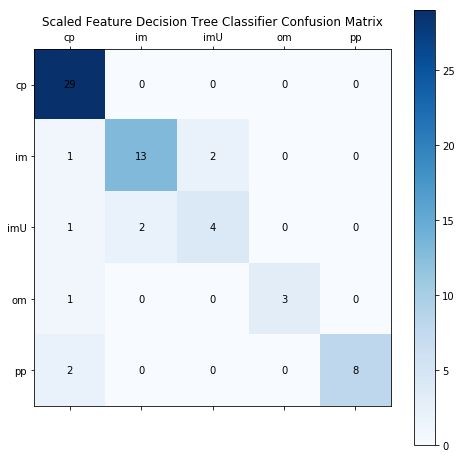

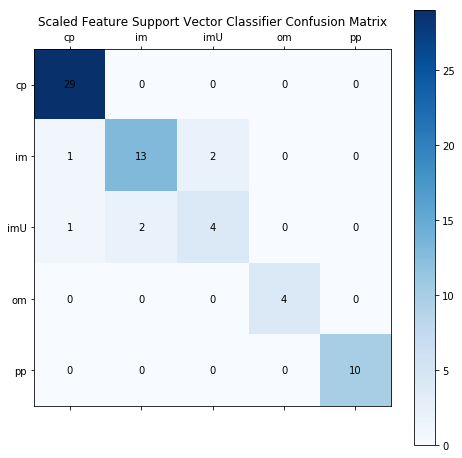

In [30]:
plot_confusion_matrix(confusion_matrix(y_test, dt_test_predict), "Scaled Feature Decision Tree Classifier Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test, svm_test_predict), "Scaled Feature Support Vector Classifier Confusion Matrix")

From the above plots we can see that the SVC has much stronger predictions along the diagonal with little error between the different classes compared with the Decision Tree Classifier which appears to incorrectly predict `cp` as `pp` at times.

Both models appear to incorrectly classify between `im` and `imU` but it appears to be less prevalent in the Support Vector Classifier, which predicts `im` class better than the Decision Tree Classifier.

### DT and Support Vector Classifier Unnormalized (Unscaled feature set)
Fit the unscaled data to the DT and Support Vector Machine and compare the results between each model with and without scaling of the features.

In [15]:
# Create unscaled DT Classifier
dt_raw = DecisionTreeClassifier(random_state=random_seed).fit(X_train, y_train)
dt_raw_y_test_predict = dt_raw.predict(X_test)

# Cross Validate the prediction of an unscaled DT classifier
dt_raw_y_predict = cross_val_score(dt_raw, X_test, y_test, cv=3)

# Create Unscaled SVM
svm_raw = SVC(gamma="auto", random_state=random_seed, kernel="linear").fit(X_train, y_train)
svm_raw_y_test_predict = svm_raw.predict(X_test)

# Cross validate the prediction of the unscaled SVM
svm_raw_y_predict = cross_val_score(svm_raw, X_test, y_test, cv=3)

### Compare scaled and unscaled model performance
Using Confusion Matrix, F1 Score and Cross Validation of predictions on the testing set.

First lets see the accuracy of the two models trained on both the scaled and unscaled datasets.

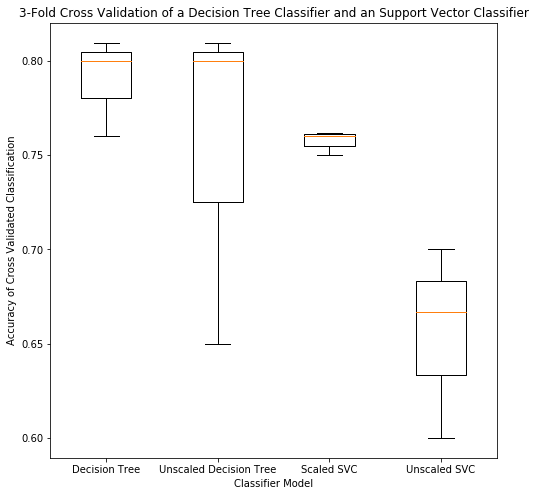

In [16]:
# Visualise the results in a bar graph
plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, dt_raw_y_predict, svm_y_predict, svm_raw_y_predict], labels=["Decision Tree", "Unscaled Decision Tree", "Scaled SVC", "Unscaled SVC"])
plt.title("3-Fold Cross Validation of a Decision Tree Classifier and an Support Vector Classifier")
plt.ylabel("Accuracy of Cross Validated Classification")
plt.xlabel("Classifier Model")
plt.show()

In the Support Vector classifiers the mean accuracy is fignificantly effected as is its range. However, in the decision tree validation the mean is unaffected but the lower range has been.

In [17]:
dt_raw_f1 = f1_score(y_test, dt_raw_y_test_predict, average="micro")
svm_raw_f1 = f1_score(y_test, svm_raw_y_test_predict, average="micro")

print("Models on scaled features F1 Scores:\nDecision Tree: %.6f%% \tSVM: %.6f%%\n" % (dt_f1, svm_f1))
print("Models on unscaled features F1 Scores:\nDecision Tree: %.6f%% \tSVM: %.6f%%" % (dt_raw_f1, svm_raw_f1))

Models on scaled features F1 Scores:
Decision Tree: 0.863636% 	SVM: 0.909091%

Models on unscaled features F1 Scores:
Decision Tree: 0.863636% 	SVM: 0.833333%


As expected Support Vector Machines are highly variable based on the feature scaling present. This is shown through the significantly lower f1 score of `83%` of the SVM trained on the unscaled data compared with the `91%` score of the SVM trained on the scaled data. The Decision Tree trained on unscaled data does not change the models F1 score at all, and confirms that feature scaling does not effect Decision Tree Classifiers in the same way as SVM.

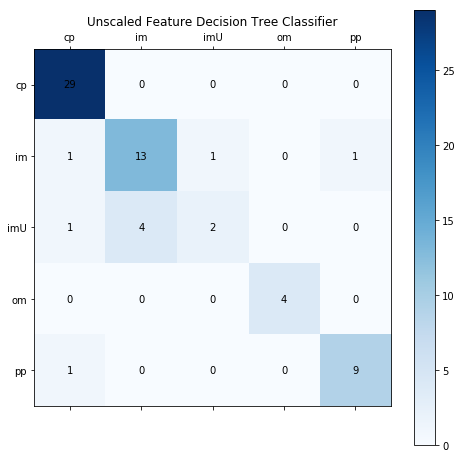

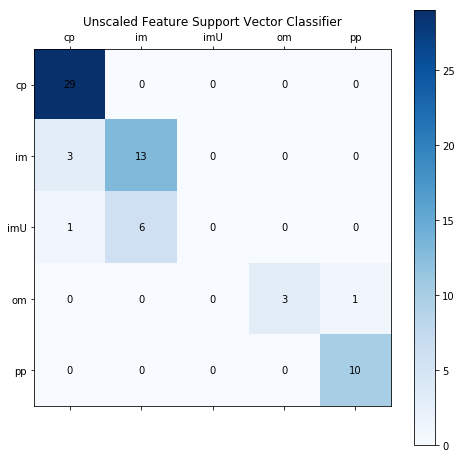

In [31]:
plot_confusion_matrix(confusion_matrix(y_test, dt_raw_y_test_predict),"Unscaled Feature Decision Tree Classifier")
plot_confusion_matrix(confusion_matrix(y_test, svm_raw_y_test_predict),"Unscaled Feature Support Vector Classifier")

Compared with the scaled confusion matrices we can clearly see that the DT does relatively well when the data is both scaled or unscaled. However, the SVC is unable to predict the `imU` class as well as the scaled SVC and both Decision Trees trained on scaled and unscaled features. Suggesting that it should probably not be used.

## Comparison of DT and SVM Models
From these results it appears that the unscaled Decision Tree Classifier would be preferred to that of the unscaled SVM Classifier. However, when scaling is applied to the data the SVM Classifier with a linear kernal outperforms the Decision Tree Classifier in its F1 score and the resulting confusion matrix, but its cross-validated accuracy is lower. This is as a result of the SVM being able to fit a wider street on the scaled dataset, and so improves the accuracy of prediction, where as the Decision Tree is unaffected by scaling as it only looks for threshold values to split samples.

# Project 2 - BOM Dataset
### Summary:
- Load datasets and create a DT and SVM regressor capable of predicting the maximum temperature based on the solar exposure and a month and date.
- Report the MSE of the two regressors

### Load and Clean the Data
##### Load Data from `./SolarExposure_2018_Data.csv` and `./Temperature_2018_Data.csv`

In [19]:
solar_exposure = pd.read_csv("./SolarExposure_2018_Data.csv")
per_temp = pd.read_csv("./Temperature_2018_Data.csv")

print(solar_exposure.describe())
per_temp.describe()

       Bureau of Meteorology station number    Year       Month         Day  \
count                                 365.0   365.0  365.000000  365.000000   
mean                                 9225.0  2018.0    6.526027   15.720548   
std                                     0.0     0.0    3.452584    8.808321   
min                                  9225.0  2018.0    1.000000    1.000000   
25%                                  9225.0  2018.0    4.000000    8.000000   
50%                                  9225.0  2018.0    7.000000   16.000000   
75%                                  9225.0  2018.0   10.000000   23.000000   
max                                  9225.0  2018.0   12.000000   31.000000   

       Daily global solar exposure (MJ/m*m)  
count                            365.000000  
mean                              18.883014  
std                                7.771997  
min                                2.900000  
25%                               12.200000  
50%         

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature
count,365.0,365.0,365.000000,365.000000,365.000000,365.0
mean,9225.0,2018.0,6.526027,15.720548,24.654795,1.0
std,0.0,0.0,3.452584,8.808321,5.566018,0.0
min,9225.0,2018.0,1.000000,1.000000,14.100000,1.0
25%,9225.0,2018.0,4.000000,8.000000,20.000000,1.0
50%,9225.0,2018.0,7.000000,16.000000,24.200000,1.0
75%,9225.0,2018.0,10.000000,23.000000,28.700000,1.0
max,9225.0,2018.0,12.000000,31.000000,41.200000,1.0


We dont need the `Product code` and the `Bureau of meterology station number` as the only inputs into these regressors will be the date, solar exposure and a prediction of the maximum tempterature. Based on the .txt file most of the data quality has been checked and it is unlikely that the quality of a N instance will be particularly bad so lets remove that row as well.

From the description of the `per_temp` dataset the days of accumulation is all 1 and we know the data is only from 2018 so we can remove the `Year` and `days of accumulation` feature. If the data set included data from other years besides 2018 we would have kept the year, but otherwise it will likely reduce the accuracy of the regressor models as when scaled all of the year feature values will be a constant 1.0 and will result inaccuracy of the fitted model on the data (based on when I tested it).

In [20]:
# Common columns to remove from each dataset.
drop_cols = ["Year","Product code", "Bureau of Meteorology station number"]

solar_exposure = solar_exposure.drop(drop_cols, axis=1)
per_temp = per_temp.drop(drop_cols + ["Quality", "Days of accumulation of maximum temperature"], axis=1)

We need to be do a regression using the date and global solar exposure to predict maximum tempterature so lets merge datasets on the date columns.

In [21]:
# The columns to merge the two datasets on
merge_cols = ["Month", "Day"]

combined_data = pd.merge(solar_exposure, per_temp, how="left", left_on=merge_cols, right_on=merge_cols)

# Lets initially view the correlation between variables now that we have the dataset
combined_data.corr()

,Month,Day,Daily global solar exposure (MJ/m*m),Maximum temperature (Degree C)
Month,1.000000,0.011893,0.103432,-0.307392
Day,0.011893,1.000000,0.015080,0.006236
Daily global solar exposure (MJ/m*m),0.103432,0.015080,1.000000,0.652676
Maximum temperature (Degree C),-0.307392,0.006236,0.652676,1.000000


We can see that the maximum temperature is most closely related to the daily global solar exposure and is slightly correlated to the month, whilst the day is not particularly correlated.

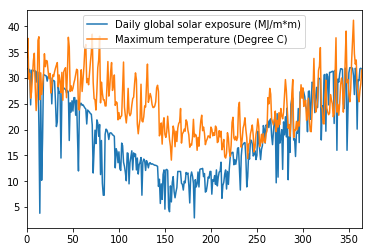

In [22]:
# Get an overview of the shape of the data coming in.
combined_data[["Daily global solar exposure (MJ/m*m)", "Maximum temperature (Degree C)"]].plot()
plt.show()

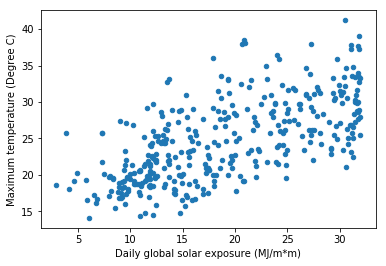

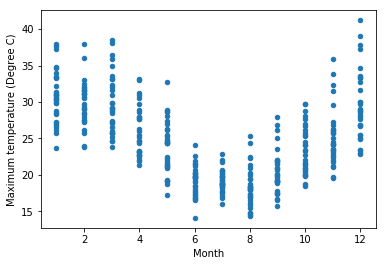

In [23]:
# Compare solar exposure with respect to maximum temperature
combined_data.plot.scatter(x='Daily global solar exposure (MJ/m*m)', y='Maximum temperature (Degree C)')
combined_data.plot.scatter(x='Month', y='Maximum temperature (Degree C)')
plt.show()

From the above plot there appears to be a relatively linear trend in the maximum temperature based on the global solar exposure which would be expected. However there appears to be quite a lot of variability which is likely to do with the time of year.

Looking at the Month and Maximum temperature we can see the correlation suggested earlier between temperature and the month can be seen in the parabolic shape of the data.

### Create Training and Test Datasets
Split the data in a 20/80 split for training and testing using a ShuffleSplit as it allows us to split on a given test size quite easily. We can't use StratifiedShuffleSplit as we have no classes as this is a regression problem.

In [24]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(train_size=0.8, test_size=0.2, random_state=random_seed)

target = "Maximum temperature (Degree C)"

for train_index, test_index in ss.split(combined_data.iloc[:, :len(combined_data.columns)-2], combined_data[target]):
    X_train2, X_test2 = combined_data.iloc[train_index], combined_data.iloc[test_index]
    y_train2, y_test2 = combined_data.iloc[train_index][target], combined_data.iloc[test_index][target]

X_train2 = X_train2.drop("Maximum temperature (Degree C)", axis=1)
X_test2 = X_test2.drop("Maximum temperature (Degree C)", axis=1)

Create feature scaled datasets to allow us to compare the results of the these regressors on scaled and unscaled feature sets

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True)
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

c:\users\gosia\documents\cits5508\venv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Fit DecisionTreeRegressor and SVM Regressor
We can later compare the accuracy of each of these models and then compare how these models respond to scaled and unscaled feature sets.

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# DTR on a scaled feature set
dtr = DecisionTreeRegressor(criterion="mae", min_samples_leaf=10, random_state=random_seed).fit(X_train2_scaled, y_train2)

# Predict on the training set
dtr_train_predict = dtr.predict(X_train2_scaled)
# Predict on the testing set
dtr_test_predict = dtr.predict(X_test2_scaled)


# SVR on a scaled feature set
svr = SVR(gamma="scale", C=80, epsilon=1.5, kernel="rbf").fit(X_train2_scaled, y_train2)

# Predict on training set
svr_train_predict = svr.predict(X_train2_scaled)
# Predict on testing set
svr_test_predict = svr.predict(X_test2_scaled)

For the Decision Regressor the hyper-parameters were selected based on their effect on the Mean Squared Error of the regressor on the test data (shown in the next section). Using `criterion='mae'` appeared to lower the MSE, as did setting `min_samples_leaf=10` to restrict overfitting of the decision tree to the training data.

Similarly for the SupportVector Regressor using `gamma='scale'` appeared to lower the MSE compared with using `auto` for this. The `C=80` and `epsilon=1.5` was determined based on trial and error on the test data.

Compare each of the regressor's mean squared error when fitted to a scaled feature set on both the training and test sets. 

In [27]:
from sklearn.metrics import mean_squared_error

# Decision Tree MSE on Scaled Training and Test Features
dtr_mse_train = mean_squared_error(y_train2, dtr_train_predict)
dtr_mse_test = mean_squared_error(y_test2, dtr_test_predict)

# Support Vector MSE on Scaled Training and Test Features
svm_mse_train = mean_squared_error(y_train2, svr_train_predict)
svm_mse_test = mean_squared_error(y_test2, svr_test_predict)

# Format output of errors
print("Scaled Regressors Mean Square Error on Training Dataset:\nDecision Tree Regression: %.6f\tSupport Vector Regression: %.6f\n" % (dtr_mse_train, svm_mse_train))
print("Scaled Regressors Mean Square Error on Test Dataset:\nDecision Tree Regression: %.6f\tSupport Vector Regression: %.6f" % (dtr_mse_test, svm_mse_test))

Scaled Regressors Mean Square Error on Training Dataset:
Decision Tree Regression: 9.132911	Support Vector Regression: 8.154715

Scaled Regressors Mean Square Error on Test Dataset:
Decision Tree Regression: 11.177534	Support Vector Regression: 9.862268


From the scaled dataset the results above show that the Support Vector Regressor slightly better on both the training `8.15` and test `9.86` sets compared with the Decision Tree Regressor results of `9.13` and `11.18` on the training and test sets respectively.

Lets compare how these regressors perform on unscaled datasets, using the same hyper-parameters.

In [28]:
# DTR on an unscaled feature set
dtr_raw = DecisionTreeRegressor(criterion="mae", min_samples_leaf=10, random_state=random_seed).fit(X_train2, y_train2)
dtr_raw_train_predict = dtr_raw.predict(X_train2)
dtr_raw_test_predict = dtr_raw.predict(X_test2)

# SVR on an unscaled feature set
svr_raw = SVR(gamma="scale", C=80, epsilon=1.5, kernel="rbf").fit(X_train2, y_train2)
svr_raw_train_predict = svr_raw.predict(X_train2)
svr_raw_test_predict = svr_raw.predict(X_test2)

In [29]:
# Unscaled Regressor Errors on testing and training sets
dt_raw_mse_train = mean_squared_error(y_train2, dtr_raw_train_predict)
dt_raw_mse = mean_squared_error(y_test2, dtr_raw_test_predict)

svm_raw_mse_train = mean_squared_error(y_train2, svr_raw_train_predict)
svm_raw_mse = mean_squared_error(y_test2, svr_raw_test_predict)
print("Unscaled Regressors Mean Square Error on Training Dataset\nDecision Tree Regression: %.6f\tSupport Vector Regression: %.6f\n" % (dt_raw_mse_train, svm_raw_mse_train))
print("Unscaled Regressors Mean Square Error on Testing Dataset\nDecision Tree Regression: %.6f\tSupport Vector Regression: %.6f" % (dt_raw_mse, svm_raw_mse))

Unscaled Regressors Mean Square Error on Training Dataset
Decision Tree Regression: 9.132911	Support Vector Regression: 9.620844

Unscaled Regressors Mean Square Error on Testing Dataset
Decision Tree Regression: 11.223562	Support Vector Regression: 10.751667


We can again see that feature scaling does not particularly effect the Decision Tree's prediction accuracy and interestingly does not significantly effect the Support Vector Regressor's accuracy. The decrease in the Decision Tree MSE trained on the unscaled feature set predicted against the test set, suggests that due to a decision threshold the tree's generated are slightly different on the scaled and unscaled features, and hence result in the observed differences in its prediction error.

Based on the MSE of these two regressors the Support Vector Regressor trained on the unscaled set achieves as much lower MSE than the Decision Tree Regressor. Surpisingly the SVR trained on unscaled features manages to still beat the Decision Tree Regressor.

### Comparison
From these results it appears that the Support Vector Regressor is again effected by feature scaling, whilst the Decision Tree is mostly uneffected by the scaling. From both the scaled and unscaled feature set results we can see that the Support Vector Regressor with well set hyper-parameters is capable of just out-performing the Decision Tree Regressor in terms of errors. These results would occur due to the SVR's ability to fit many instances to a 'street'.

For this problem I would recommend using the Support Vector Regressor based on its current performance, but if more data over a number of years was added analysis would have to be performed again to assess its performance.